An interactive introduction to Noodles: translating Poetry
==========================================================

Noodles is there to make your life easier, *in parallel*! The reason why Noodles can be easy and do parallel Python at the same time is its *functional* approach. In one part you'll define a set of functions that you'd like to run with Noodles, in an other part you'll compose these functions into a *workflow graph*. To make this approach work a function should not have any *side effects*. Let's not linger and just start noodling! First we define some functions to use.

In [1]:
from noodles import schedule

@schedule
def add(x, y):
    return x + y

@schedule
def mul(x,y):
    return x * y

Now we can create a workflow composing several calls to this function.

In [2]:
a = add(1, 1)
b = mul(a, 2)
c = add(a, a)
d = mul(b, c)

That looks easy enough; the funny thing is though, that nothing has been computed yet! Noodles just created the workflow graphs corresponding to the values that still need to be computed. Until such time, we work with the *promise* of a future value. Using some function in `pygraphviz` we can look at the call graphs.

In [3]:
from noodles.tutorial import get_workflow_graph
import ipywidgets as widgets

widgets.HBox([
    widgets.VBox([
        widgets.HTML('<b>{}</b>'.format(k)),
        widgets.HTML(value=get_workflow_graph(w).pipe(format='svg').decode())])
    for k, w in {'a': a, 'b': b, 'c': c, 'd': d}.items()])

Widget Javascript not detected.  It may not be installed or enabled properly.
Widget Javascript not detected.  It may not be installed or enabled properly.


Now, to compute the result we have to tell Noodles to evaluate the program.

In [4]:
from noodles import run_parallel

run_parallel(d, n_threads=2)

16

## Making loops

Thats all swell, but how do we make a parallel loop? Let's look at a `map` operation; in Python there are several ways to perform a function on all elements in an array. For this example, we will translate some words using the Glosbe service, which has a nice REST interface. We first build some functionality to use this interface.

In [7]:
import urllib.request
import json
import re


class Translate:
    """Translate words and sentences in the worst possible way. The Glosbe dictionary
    has a nice REST interface that we query for a phrase. We then take the first result.
    To translate a sentence, we cut it in pieces, translate it and paste it back into
    a Frankenstein monster."""
    def __init__(self, src_lang='en', tgt_lang='fy'):
        self.src = src_lang
        self.tgt = tgt_lang
        self.url = 'https://glosbe.com/gapi/translate?' \
                   'from={src}&dest={tgt}&' \
                   'phrase={{phrase}}&format=json'.format(
                        src=src_lang, tgt=tgt_lang)
    
    def query_phrase(self, phrase):
        with urllib.request.urlopen(self.url.format(phrase=phrase.lower())) as response:
            translation = json.loads(response.read().decode())
        return translation

    def word(self, phrase):
        # translation = self.query_phrase(phrase)
        translation = {'tuc': [{'phrase': {'text': phrase.lower()[::-1]}}]}
        if len(translation['tuc']) > 0 and 'phrase' in translation['tuc'][0]:
            result = translation['tuc'][0]['phrase']['text']
            if phrase[0].isupper():
                return result.title()
            else:
                return result            
        else:
            return "<" + phrase + ">"
    
    def sentence(self, phrase):
        words = re.sub("[^\w]", " ", phrase).split()
        space = re.sub("[\w]+", "{}", phrase)
        return space.format(*map(self.word, words))

We start with a list of strings that desparately need translation.

In [8]:
shakespeare = [
    "If music be the food of love, play on,",
    "Give me excess of it; that surfeiting,",
    "The appetite may sicken, and so die."]

def print_poem(intro, poem):
    print(intro)
    for line in poem:
        print("     ", line)
    print()

print_poem("Original:", shakespeare)

Original:
      If music be the food of love, play on,
      Give me excess of it; that surfeiting,
      The appetite may sicken, and so die.



Beginning Python programmers like to append things; this is not how you are
supposed to program in Python; if you do, please go and read Jeff Knupp's *Writing Idiomatic Python*.

In [9]:
shakespeare_auf_deutsch = []
for line in shakespeare:
    shakespeare_auf_deutsch.append(
        Translate('en', 'de').sentence(line))
print_poem("Auf Deutsch:", shakespeare_auf_deutsch)

Auf Deutsch:
      Fi cisum eb eht doof fo evol, yalp no,
      Evig em ssecxe fo ti; taht gnitiefrus,
      Eht etiteppa yam nekcis, dna os eid.



Rather use a comprehension like so:

In [10]:
shakespeare_ynt_frysk = \
    (Translate('en', 'fy').sentence(line) for line in shakespeare)
print_poem("Yn it Frysk:", shakespeare_ynt_frysk)

Yn it Frysk:
      Fi cisum eb eht doof fo evol, yalp no,
      Evig em ssecxe fo ti; taht gnitiefrus,
      Eht etiteppa yam nekcis, dna os eid.



Or use `map`:

In [11]:
shakespeare_pa_dansk = \
    map(Translate('en', 'da').sentence, shakespeare)
print_poem("På Dansk:", shakespeare_pa_dansk)

På Dansk:
      Fi cisum eb eht doof fo evol, yalp no,
      Evig em ssecxe fo ti; taht gnitiefrus,
      Eht etiteppa yam nekcis, dna os eid.



## Noodlify!
If your connection is a bit slow, you may find that the translations take a while to process. Wouldn't it be nice to do it in parallel? How much code would we have to change to get there in Noodles? Let's take the slow part of the program and add a `@schedule` decorator, and run! Sadly, it is not that simple. We can add `@schedule` to the `word` method. This means that it will return a promise. 

* Rule: *Functions that take promises need to be scheduled functions, or refer to a scheduled function at some level.* 

We could write

    return schedule(space.format)(*(self.word(w) for w in words))
    
in the last line of the `sentence` method, but the string format method doesn't support wrapping. We rely on getting the signature of a function by calling `inspect.signature`. In some cases of build-in function this raises an exception. We may find a work around for these cases in future versions of Noodles. For the moment we'll have to define a little wrapper function.

In [12]:
from noodles import schedule


@schedule
def format_string(s, *args, **kwargs):
    return s.format(*args, **kwargs)


import urllib.request
import json
import re


class Translate:
    """Translate words and sentences in the worst possible way. The Glosbe dictionary
    has a nice REST interface that we query for a phrase. We then take the first result.
    To translate a sentence, we cut it in pieces, translate it and paste it back into
    a Frankenstein monster."""
    def __init__(self, src_lang='en', tgt_lang='fy'):
        self.src = src_lang
        self.tgt = tgt_lang
        self.url = 'https://glosbe.com/gapi/translate?' \
                   'from={src}&dest={tgt}&' \
                   'phrase={{phrase}}&format=json'.format(
                        src=src_lang, tgt=tgt_lang)
    
    def query_phrase(self, phrase):
        with urllib.request.urlopen(self.url.format(phrase=phrase.lower())) as response:
            translation = json.loads(response.read().decode())
        return translation
    
    @schedule
    def word(self, phrase):
        translation = {'tuc': [{'phrase': {'text': phrase.lower()[::-1]}}]}
        # translation = self.query_phrase(phrase)
        
        if len(translation['tuc']) > 0 and 'phrase' in translation['tuc'][0]:
            result = translation['tuc'][0]['phrase']['text']
            if phrase[0].isupper():
                return result.title()
            else:
                return result            
        else:
            return "<" + phrase + ">"
        
    def sentence(self, phrase):
        words = re.sub("[^\w]", " ", phrase).split()
        space = re.sub("[\w]+", "{}", phrase)
        return format_string(space, *map(self.word, words))
    
    def __str__(self):
        return "[{} -> {}]".format(self.src, self.tgt)
    
    def __serialize__(self, pack):
        return pack({'src_lang': self.src,
                     'tgt_lang': self.tgt})

    @classmethod
    def __construct__(cls, msg):
        return cls(**msg)

Let's take stock of the mutations to the original. We've added a `@schedule` decorator to `word`, and changed a function call in `sentence`. Also we added the `__str__` method; this is only needed to plot the workflow graph. Let's run the new script.

In [13]:
from noodles import gather, run_parallel

shakespeare_en_esperanto = \
    map(Translate('en', 'eo').sentence, shakespeare)

wf = gather(*shakespeare_en_esperanto)

In [14]:
result = run_parallel(wf, n_threads=8)
print_poem("Shakespeare en Esperanto:", result)

Shakespeare en Esperanto:
      Fi cisum eb eht doof fo evol, yalp no,
      Evig em ssecxe fo ti; taht gnitiefrus,
      Eht etiteppa yam nekcis, dna os eid.



The last peculiar thing that you may notice, is the `gather` function. It collects the promises that `map` generates and creates a single new promise. The definition of `gather` is very simple:
    
    @schedule
    def gather(*lst):
        return lst

The workflow graph of the Esperanto translator script looks like this:

In [15]:
# if you know a way to shrink this image down, please send me a pull request
widgets.HTML(get_workflow_graph(wf).pipe(format='svg').decode())

## Dealing with repetition
In the following example we have a line with some repetition. It would be a shame to look up the repeated words twice, wouldn't it? Let's build a little counter routine to check if everything is working.

In [12]:
from noodles import (schedule, gather_all)
import re

@schedule
def count_word_size(word):
    return len(word)

@schedule
def format_string(s, *args, **kwargs):
    return s.format(*args, **kwargs)

def word_sizes(phrase):
    words = re.sub("[^\w]", " ", phrase).split()
    space = re.sub("[\w]+", "{}", phrase)
    word_lengths = map(count_word_size, words)
    return format_string(space, *word_lengths)

In [13]:
from noodles.run.threading.vanilla import run_parallel

line = "Oote oote oote, Boe"
run_parallel(word_sizes(line), n_threads=4)

'4 4 4, 3'

To see how this program is being run, we monitor the job submission, retrieval and result storage in a Sqlite3 database.

In [37]:
logging.FileHandler(filename='mylog.log', mode='a')

Activating auto-logging. Current session state plus future input saved.
Filename       : noodles
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [43]:
from noodles.run.threading.sqlite3 import run_parallel
from noodles import serial

wf = Translate('de', 'fr').sentence(line)
run_parallel(wf, n_threads=4, registry=serial.base, db_file='jobs.db')

INFO:noodles.incoming-jobs:job 11: word([de -> fr], Mein)
INFO:noodles.incoming-jobs:job 12: word([de -> fr], Gott)
INFO:noodles.incoming-jobs:job 13: word([de -> fr], mein)
INFO:noodles.incoming-jobs:job 14: word([de -> fr], Gott)
INFO:noodles.incoming-jobs:job 15: word([de -> fr], warum)
INFO:noodles.incoming-jobs:job 16: word([de -> fr], hast)
INFO:noodles.incoming-jobs:job 17: word([de -> fr], Du)
INFO:noodles.incoming-jobs:job 18: word([de -> fr], mich)
INFO:noodles.incoming-jobs:job 19: word([de -> fr], verlassen)
INFO:noodles.outgoing-results:result 11 [word([de -> fr], Mein)]: retrieved Niem
INFO:noodles.outgoing-results:result 12 [word([de -> fr], Gott)]: retrieved Ttog
INFO:noodles.outgoing-results:result 13 [word([de -> fr], mein)]: retrieved niem
INFO:noodles.outgoing-results:result 14 [word([de -> fr], Gott)]: retrieved Ttog
INFO:noodles.outgoing-results:result 15 [word([de -> fr], warum)]: retrieved muraw
INFO:noodles.outgoing-results:result 16 [word([de -> fr], hast)]: r

'Niem Ttog, niem Ttog, muraw tsah Ud hcim nessalrev?'

Try running the above cells again, and see what happens!

## Objects in Noodles

We've already seen that we can `@schedule` class methods, just as easy as functions. What if a promised objects represents an object? Noodles actually catches references and assignments to perceived members of promised objects and translates them into function calls. We will have another example (this time a bit smaller) to show how this works. We will compute result to Pythagoras theorem by using setters and getters. Python has a beautiful way of capturing reference and assignment to member variables by means of the `@property` decorator. This concept alows Noodles to catch these in a most generic way.

In [18]:
from noodles import schedule

@schedule
class A:
    def __init__(self, value):
        self.value = value

    @property
    def square(self):
        return self.value**2

    @square.setter
    def square(self, sqr):
        self.value = sqr**(1/2)
        
    def __str__(self):
        return "[A {}]".format(self.value)

We can now treat this object as normal in the user script, and do the following

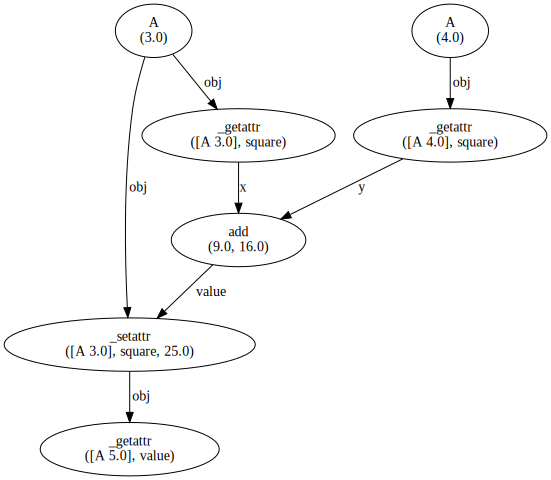

In [19]:
from noodles import run_single
from noodles.tutorial import add

u = A(3.0)
v = A(4.0)
u.square = add(u.square, v.square)
w = u.value

run_single(w)
get_workflow_graph(w)

Note that, to make this work in general parallel situations, the `_setattr` function has to create a deepcopy of the object and then return the modified object; so this style of programming can become quite expensive. A better solution would be to create a layered system, where updates only affect the values that are being updated.

## User messages
If jobs take a long time (>1s) to run, it is nice to give the user a message when it starts, when it finishes and if it was a success. Noodles has an adaptor for runners to display messages.

In [20]:
from noodles import (schedule_hint, gather)
from noodles.tutorial import (sub, mul, accumulate)
from noodles.display import (DumbDisplay)
from noodles.run.runners import (run_parallel_with_display)
import time


@schedule_hint(display="|   {a} + {b}", confirm=True)
def add(a, b):
    time.sleep(0.5)
    return a + b


@schedule_hint(display="{msg}")
def message(msg, value=0):
    return value()


def test_logging():
    A = add(1, 1)
    B = sub(3, A)

    multiples = [mul(add(i, B), A) for i in range(6)]
    C = accumulate(gather(*multiples))
    wf = message("\n+---(Running the test)", lambda: C)

    with DumbDisplay() as display:
        result = run_parallel_with_display(wf, n_threads=4, display=display)
    print("\nThe answer is ", result)

We imported some predefined functions from `noodles.tutorial`. A new function that we haven't seen before is `@schedule_hint`. It does the same as `@schedule`, but now it also attaches some information to the function. This can be anything. Here we add a `display` string. This string is formatted using the arguments to the function that is being called. 

In [14]:
import threading
threading.Thread(target=test_logging, daemon=True).start()

[START]      | 
+---(Running the test)
Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib64/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib64/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/Knolselderij/johannes/Code/Noodles/noodles/noodles/lib/streams.py", line 270, in patch
    sink.send(v)
  File "/mnt/Knolselderij/johannes/Code/Noodles/noodles/noodles/lib/streams.py", line 185, in sink
    f(args)
  File "/mnt/Knolselderij/johannes/Code/Noodles/noodles/noodles/display/dumb_term.py", line 72, in __call__
    if job.hints and 'display' in job.hints:
TypeError: argument of type 'PromisedObject' is not iterable



There are other functions than `DumbDisplay` that will work. Currently there is also `NCDisplay` (NC standing for NCurses), which is the one used in the Boil example application. The `NCDisplay` assumes we are in a terminal emulator environment.

## Iteration & Recursion